# 0. Libraries

In [ ]:
pip install skrebate
pip install imbalanced-learn

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from skrebate import ReliefF

from sklearn.feature_selection import GenericUnivariateSelect, SelectKBest, mutual_info_classif, f_classif, RFE, RFECV
from sklearn.model_selection import StratifiedKFold, cross_validate, cross_val_predict, cross_val_score, validation_curve, GridSearchCV, StratifiedKFold, ShuffleSplit
from sklearn.metrics import accuracy_score, auc, confusion_matrix, f1_score, precision_score, recall_score, roc_curve, plot_roc_curve, roc_auc_score
from imblearn.combine import SMOTEENN

from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier

Using TensorFlow backend.


# 1. Descriptive analysis

In [2]:
df = pd.read_csv('data.csv')
df.head()

,quality,bits,intra_parts,skip_parts,inter_16x16_parts,inter_4x4_parts,inter_other_parts,non_zero_pixels,frame_width,frame_height,...,sobel_h,sobel_v,variance,block_movement_h,block_movement_v,var_movement_h,var_movement_v,cost_1,cost_2,relevant
0,22,2143,0,0,1,3,21,404,416,240,...,17.397461,17.397461,87.584335,2.820312,2.539062,10.772400,8.576599,0.0,0.0,1.0
1,22,1735,0,2,0,3,8,381,416,240,...,14.426758,14.233398,48.025330,1.843750,1.921875,6.163086,6.665771,8816.0,8801.0,1.0
2,22,1971,0,0,0,0,8,460,416,240,...,15.203125,13.953125,56.613480,3.000000,4.937500,1.625000,3.683594,5104.0,5193.0,1.0
3,22,2473,0,0,0,18,20,421,416,240,...,21.725586,29.165039,283.079285,2.078125,2.500000,25.806396,34.656250,21531.0,19802.0,1.0
4,22,1093,0,0,1,3,8,167,416,240,...,11.929688,14.353516,175.123245,3.070312,4.523438,22.252869,14.780701,15073.0,14549.0,1.0


In [ ]:
df.shape

In [ ]:
df.info()

In [ ]:
df.nunique()

In [ ]:
df.describe()

# 2. Data exploration

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001E945750308>,
      dtype=object)

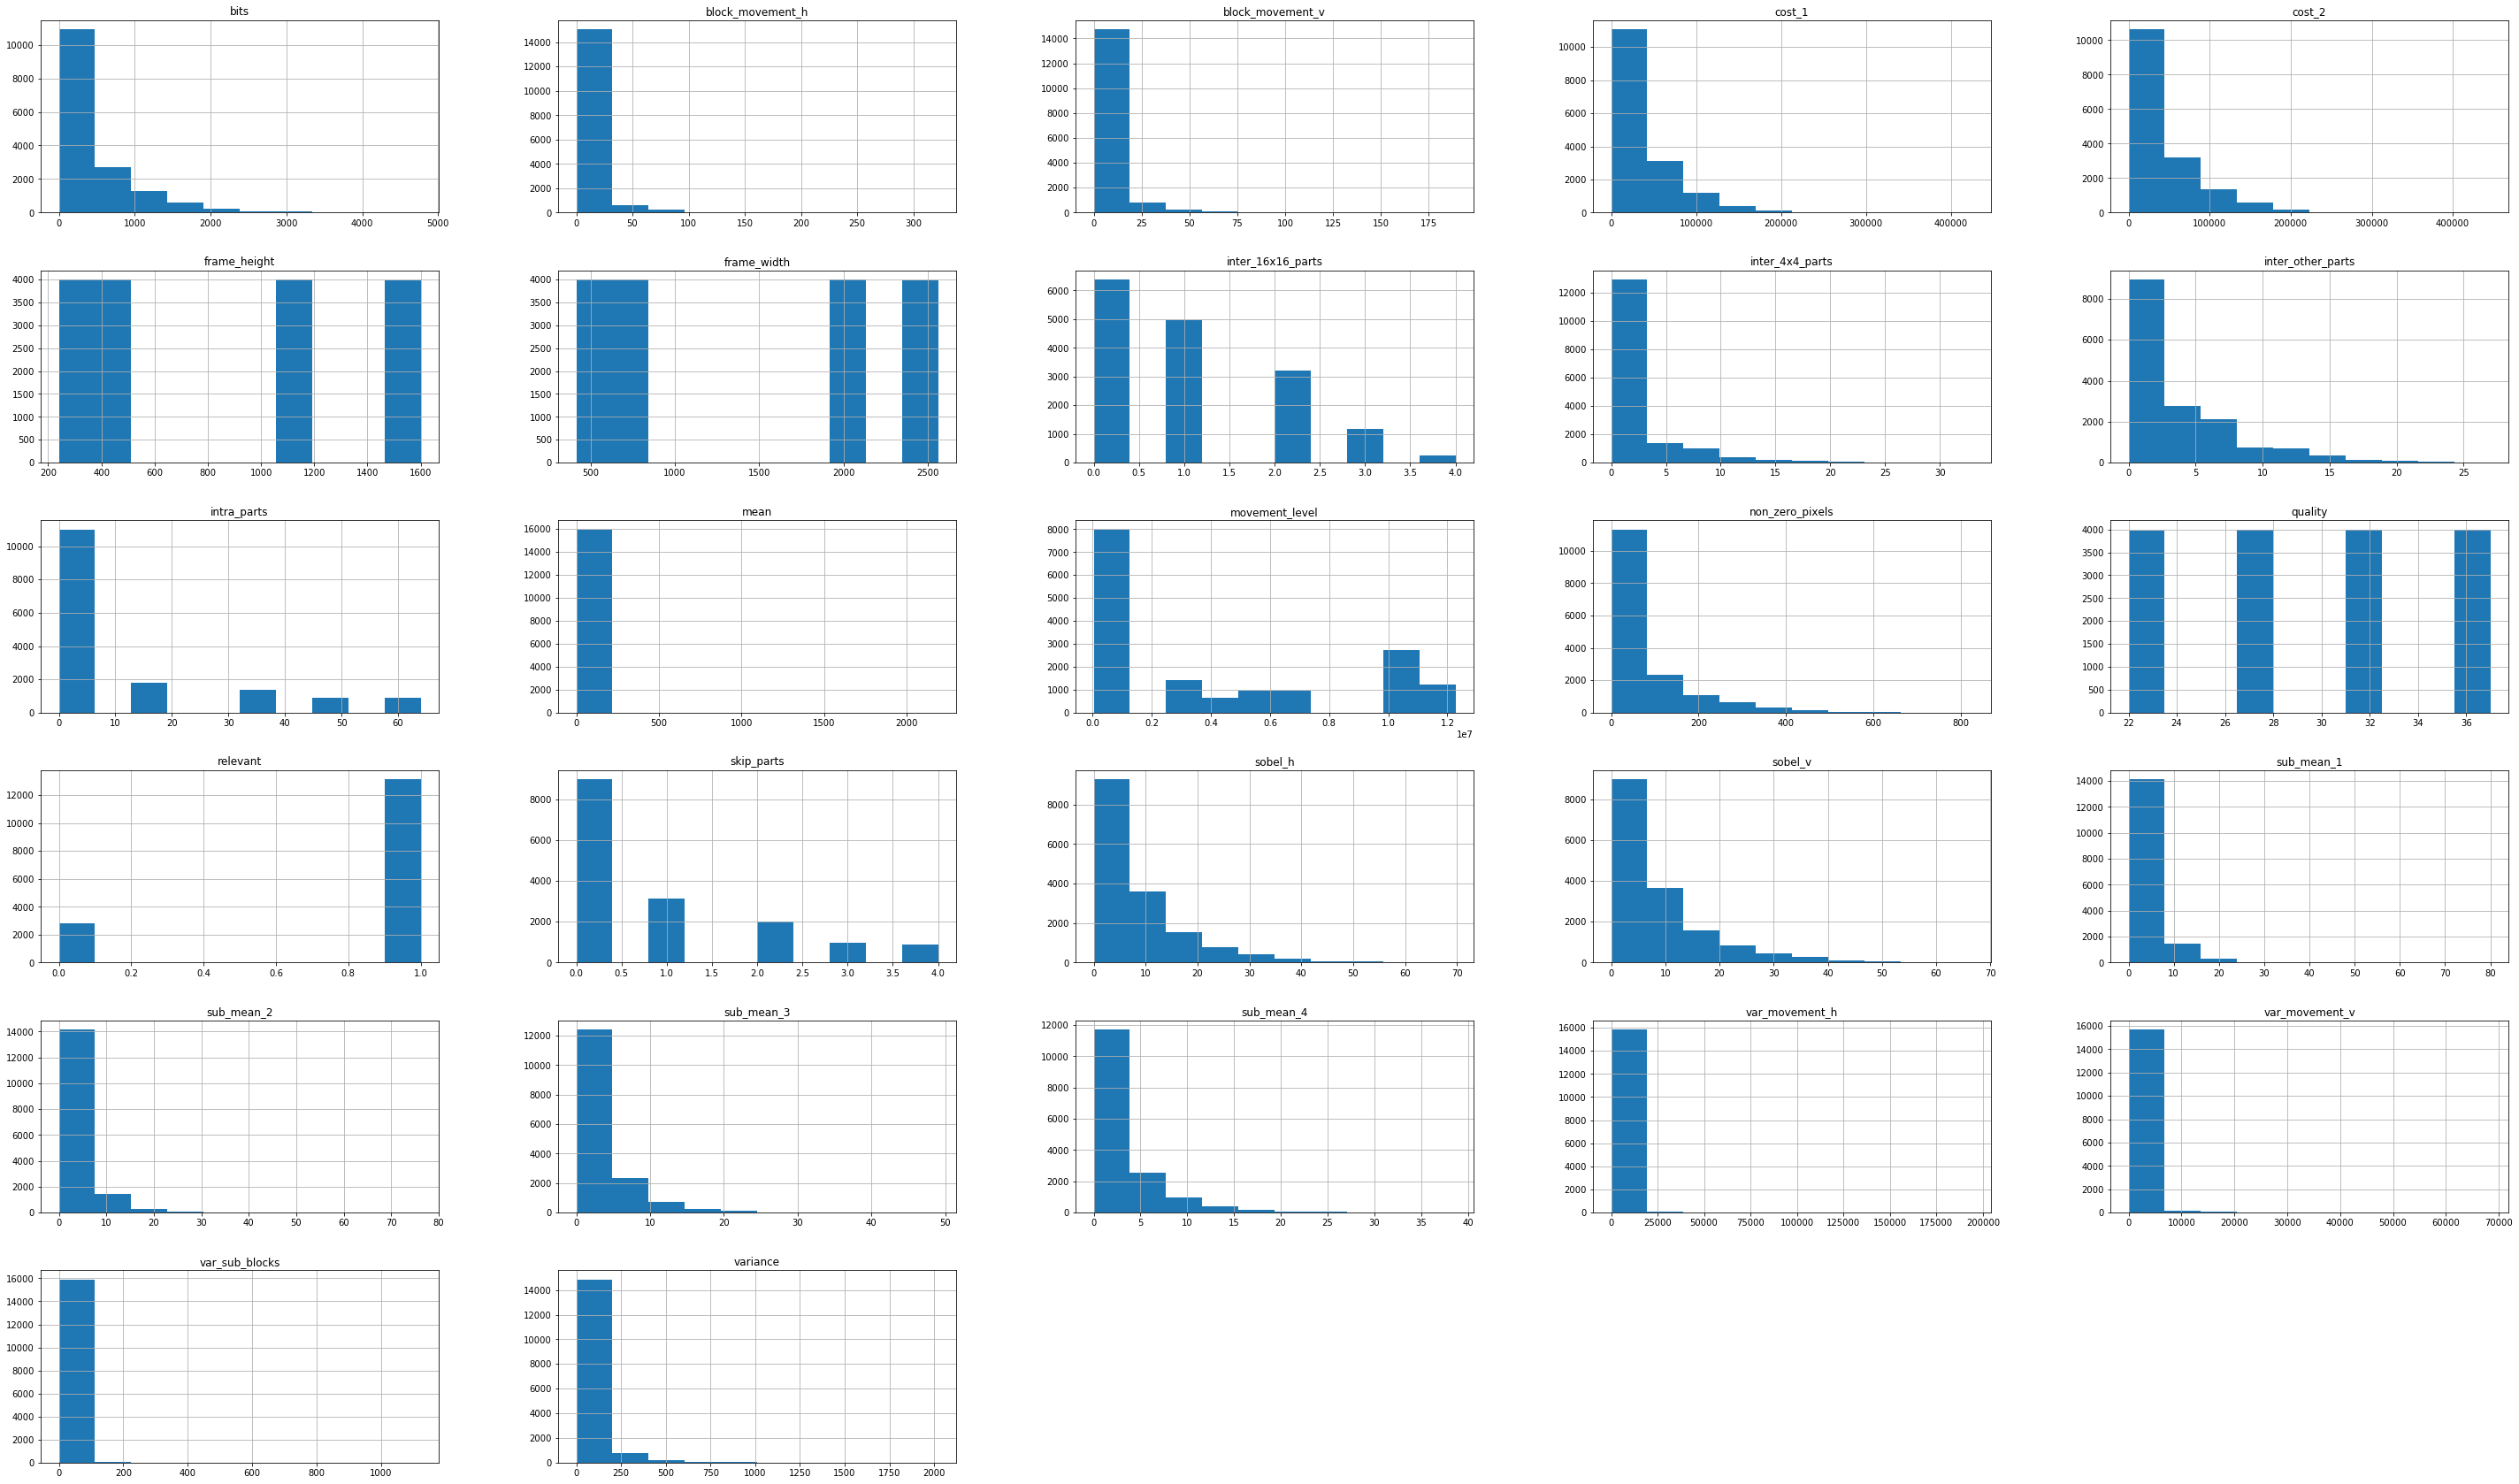

In [12]:
df.hist(figsize=(50, 30))

# 3. Data preparation

Rows with null values are dropped

In [3]:
df.dropna(inplace=True)

Training variables are assigned

In [4]:
X = df.iloc[:, :26]
y = df.iloc[:, 26:]

The response variable is imbalanced

In [5]:
df.relevant.value_counts()

1.0    13126
0.0     2841
Name: relevant, dtype: int64

SMOTE is applied for oversampling and Edited Nearest Neighbours for undersampling

In [6]:
X_resample, y_resample = SMOTEENN(sampling_strategy=0.75, random_state=0).fit_resample(X, y)
y_resample.relevant.value_counts()

1.0    7298
0.0    5594
Name: relevant, dtype: int64

Features are scaled by their maximum and minimum in the range of [0,1]

In [7]:
X = pd.DataFrame(data=MinMaxScaler(feature_range=(0, 1)).fit_transform(X), columns=X.columns)
X_resample = pd.DataFrame(MinMaxScaler(feature_range=(0, 1)).fit_transform(X_resample), columns=X_resample.columns)

## 3.1 Feature subset selection

### 3.1.1 Univariate filter (Mutual Information)

In [13]:
#Mutual Information
scores = np.zeros(26)
for i in range(0,10):
    test = SelectKBest(score_func=mutual_info_classif, k=10)
    fit = test.fit(X, np.ravel(y))
    scores = [(x + y) for x, y in zip(scores, fit.scores_)]

scores = [x/10 for x in scores]
# Summarize scores
scores = pd.DataFrame(data=scores,index=X.columns, columns=['Scores'])
scores = scores.sort_values(by='Scores', ascending=False)
print("Univariate Filter (Mutual Information)")
print(scores)

Univariate Filter (Mutual Information)
                     Scores
bits               0.061416
movement_level     0.057465
non_zero_pixels    0.055617
sub_mean_4         0.037794
sobel_h            0.036682
mean               0.035213
quality            0.034845
sobel_v            0.033693
variance           0.029262
sub_mean_3         0.028608
sub_mean_1         0.027997
skip_parts         0.027510
inter_other_parts  0.025431
var_sub_blocks     0.025098
sub_mean_2         0.025079
var_movement_h     0.022162
block_movement_h   0.019111
block_movement_v   0.019048
frame_height       0.018865
frame_width        0.018336
var_movement_v     0.017221
cost_1             0.012394
inter_4x4_parts    0.011557
intra_parts        0.010362
cost_2             0.007017
inter_16x16_parts  0.001102


### 3.1.2 Multivariate filter (Relief)

In [14]:
#Relief
fs = ReliefF()
fs.fit(np.array(X), np.concatenate(np.array(y)))
    
scores = pd.DataFrame(data=fs.feature_importances_,index=X.columns, columns=['Scores'])
scores = scores.sort_values(by='Scores', ascending=False)
print("Multivariate Filter (Relief)")
print(scores)

Multivariate Filter (Relief)
                     Scores
quality            0.188603
inter_16x16_parts  0.111704
bits               0.110346
non_zero_pixels    0.102117
skip_parts         0.098555
sobel_h            0.069612
sobel_v            0.069012
inter_other_parts  0.061656
cost_2             0.060023
cost_1             0.056129
frame_height       0.053389
frame_width        0.053389
sub_mean_4         0.045511
intra_parts        0.039161
inter_4x4_parts    0.036110
sub_mean_3         0.035667
sub_mean_1         0.033787
sub_mean_2         0.032270
variance           0.026546
block_movement_v   0.020349
block_movement_h   0.019023
movement_level     0.017877
var_sub_blocks     0.012761
var_movement_h     0.011807
var_movement_v     0.007075
mean               0.000206


### 3.1.3 Wrapper (RFE)

Optimal number of features : 18


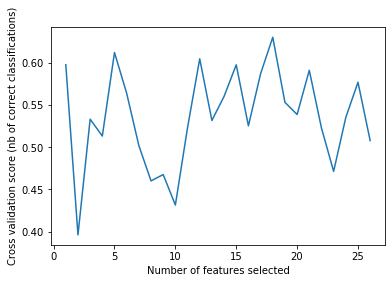

Multivariate Wrapper (RFE)
                    ROC AUC
sobel_h            0.630460
inter_16x16_parts  0.612348
mean               0.604909
quality            0.597827
sub_mean_3         0.597774
block_movement_h   0.591288
var_sub_blocks     0.587175
cost_1             0.577100
inter_4x4_parts    0.564036
sub_mean_2         0.560311
sobel_v            0.553320
variance           0.538877
var_movement_v     0.535431
intra_parts        0.533357
sub_mean_1         0.531813
sub_mean_4         0.525482
movement_level     0.523266
block_movement_v   0.522872
skip_parts         0.513356
cost_2             0.507974
inter_other_parts  0.502147
var_movement_h     0.471465
frame_width        0.467733
non_zero_pixels    0.460194
frame_height       0.431595
bits               0.396167


In [14]:
#rfe
rfecv = RFECV(estimator=SVC(kernel='linear',random_state=0), step=1, cv=5,
              scoring='roc_auc')
rfecv.fit(X, np.ravel(y))

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

scores = pd.DataFrame(data=rfecv.grid_scores_,index=X.columns, columns=['ROC AUC'])
scores = scores.sort_values(by='ROC AUC', ascending=False)
print("Multivariate Wrapper (RFE)")
print(scores)

# 4. Model learning

In [8]:
kf = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)
def showResults(model, X, y):
    results = cross_validate(model, X, y, scoring = ['accuracy', 'f1_weighted', 'precision_weighted', 'recall_weighted', 'roc_auc'], cv = kf)
    print(str(model.__class__.__name__) + ":")
    print('\t- Accuracy: \t' + str(results['test_accuracy'].mean()))
    print('\t- Precision: \t' + str(results['test_precision_weighted'].mean()))
    print('\t- Recall: \t' + str(results['test_recall_weighted'].mean()))
    print('\t- F1: \t\t' + str(results['test_f1_weighted'].mean()))
    print('\t- ROC_AUC: \t' + str(results['test_roc_auc'].mean()))

## 4.1 SVM

In [15]:
param_grid = {
    'kernel': ['rbf'],
    'gamma': ['scale', 'auto'],
    'C': [0.1, 1],
}
grid_search = GridSearchCV(SVC(random_state=0), param_grid, cv=kf)
grid_search.fit(X, np.ravel(y))
grid_search.best_params_

{'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}

In [14]:
param_grid = {
    'kernel': ['rbf'],
    'gamma': ['scale', 'auto'],
    'C': [0.1, 1],
}
grid_search = GridSearchCV(SVC(random_state=0), param_grid, cv=kf)
grid_search.fit(X_resample, np.ravel(y_resample))
grid_search.best_params_

{'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}

In [12]:
print(showResults(SVC(random_state=0), X, np.ravel(y)))
print(showResults(SVC(random_state=0), X_resample, np.ravel(y_resample)))

C:\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


SVC:
	- Accuracy: 	0.8235738164711826
	- Precision: 	0.7593949049915073
	- Recall: 	0.8235738164711826
	- F1: 		0.7618511677232875
	- ROC_AUC: 	0.7190430143284219
None
SVC:
	- Accuracy: 	0.8796148758953306
	- Precision: 	0.8796701184162947
	- Recall: 	0.8796148758953306
	- F1: 		0.8791924319512324
	- ROC_AUC: 	0.9430002541302602
None


## 4.2 Naive Bayes

In [16]:
print(showResults(GaussianNB(), X, np.ravel(y)))
print(showResults(GaussianNB(), X_resample, np.ravel(y_resample)))

GaussianNB:
	- Accuracy: 	0.5213878747361607
	- Precision: 	0.8145537107155982
	- Recall: 	0.5213878747361607
	- F1: 		0.5677043667433205
	- ROC_AUC: 	0.7425238484987239
None
GaussianNB:
	- Accuracy: 	0.7147063273783507
	- Precision: 	0.7681860642458671
	- Recall: 	0.7147063273783507
	- F1: 		0.7107623620735444
	- ROC_AUC: 	0.8489175702096302
None


## 4.3 Decision Tree

In [22]:
param_grid = { 
    'max_depth' :[5,6,7,8,9,10],
    'criterion' :['gini','entropy'],
}
grid_search = GridSearchCV(DecisionTreeClassifier(random_state = 0, splitter='best'), param_grid, cv=kf)
grid_search.fit(X, np.ravel(y))
grid_search.best_params_

{'criterion': 'entropy', 'max_depth': 5}

In [23]:
param_grid = { 
    'max_depth' :[5,6,7,8,9,10],
    'criterion' :['gini','entropy'],
}
grid_search = GridSearchCV(DecisionTreeClassifier(random_state = 0, splitter='best'), param_grid, cv=kf)
grid_search.fit(X_resample, np.ravel(y_resample))
grid_search.best_params_

{'criterion': 'gini', 'max_depth': 10}

In [26]:
print(showResults(DecisionTreeClassifier(random_state = 0, splitter='best', max_depth=5, criterion='entropy'), X, np.ravel(y)))
print(showResults(DecisionTreeClassifier(random_state = 0, splitter='best', max_depth=10, criterion='gini'), X_resample, np.ravel(y_resample)))

DecisionTreeClassifier:
	- Accuracy: 	0.8270181464972788
	- Precision: 	0.7900848182175991
	- Recall: 	0.8270181464972788
	- F1: 		0.7853985213371192
	- ROC_AUC: 	0.771004853520588
None
DecisionTreeClassifier:
	- Accuracy: 	0.8710817905918514
	- Precision: 	0.8718339806484734
	- Recall: 	0.8710817905918514
	- F1: 		0.8712068639474986
	- ROC_AUC: 	0.9077701667117009
None


## 4.4 Random Forest

In [31]:
param_grid = { 
    'n_estimators' :[25,50,75,100],
    'max_depth' :[5,6,7,8,9,10],
    'criterion' :['gini','entropy'],
}
grid_search = GridSearchCV(RandomForestClassifier(random_state = 0), param_grid, cv=kf)
grid_search.fit(X, np.ravel(y))
grid_search.best_params_

{'criterion': 'gini', 'max_depth': 10, 'n_estimators': 100}

In [32]:
param_grid = { 
    'n_estimators' :[25,50,75,100],
    'max_depth' :[5,6,7,8,9,10],
    'criterion' :['gini','entropy'],
}
grid_search = GridSearchCV(RandomForestClassifier(random_state = 0), param_grid, cv=kf)
grid_search.fit(X_resample, np.ravel(y_resample))
grid_search.best_params_

{'criterion': 'gini', 'max_depth': 10, 'n_estimators': 100}

In [33]:
print(showResults(RandomForestClassifier(random_state=0, max_depth=10, criterion='gini'), X, np.ravel(y)))
print(showResults(RandomForestClassifier(random_state=0, max_depth=10, criterion='gini'), X_resample, np.ravel(y_resample)))

RandomForestClassifier:
	- Accuracy: 	0.8317151580604175
	- Precision: 	0.8002639316767894
	- Recall: 	0.8317151580604175
	- F1: 		0.7907082281185831
	- ROC_AUC: 	0.7997107681571209
None
RandomForestClassifier:
	- Accuracy: 	0.90079062524159
	- Precision: 	0.9007374478095848
	- Recall: 	0.90079062524159
	- F1: 		0.9007370819898426
	- ROC_AUC: 	0.9652396769527736
None


## 4.5 AdaBoost

In [20]:
print(showResults(AdaBoostClassifier(random_state=0), X, np.ravel(y)))
print(showResults(AdaBoostClassifier(random_state=0), X_resample, np.ravel(y_resample)))

AdaBoostClassifier:
	- Accuracy: 	0.8252645453099602
	- Precision: 	0.7845735914122243
	- Recall: 	0.8252645453099602
	- F1: 		0.7787277876394694
	- ROC_AUC: 	0.777448910765021
None
AdaBoostClassifier:
	- Accuracy: 	0.8708501650407253
	- Precision: 	0.8710704749676255
	- Recall: 	0.8708501650407253
	- F1: 		0.8709134964427794
	- ROC_AUC: 	0.9421338636694498
None
